### Imports & helpers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

pd.set_option("display.max_columns", 100)

def print_metrics(y_true, y_pred, y_proba=None, label=""):
    """Convenience function to print classification metrics."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    msg = f"[{label}] Acc={acc:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | F1={f1:.3f}"
    if y_proba is not None:
        auc = roc_auc_score(y_true, y_proba)
        msg += f" | ROC-AUC={auc:.3f}"
    print(msg)


### Load Data

In [3]:
train = pd.read_csv("train.csv")  # has Survived
test  = pd.read_csv("test.csv")   # no Survived; for submission

print(train.shape, test.shape)
train.head()


(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()
train.describe(include="all").T
train.isna().mean().sort_values(ascending=False).head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
dtype: float64

**What you’ll notice**:

* `Age` and `Cabin` have missing values; `Embarked` sometimes missing.
* `Survived` is the target (0 = no, 1 = yes).

In [5]:
# Survival rate overall
train['Survived'].mean()

# By Sex
train.groupby('Sex')['Survived'].mean().sort_values(ascending=False)

# By Pclass (1=upper, 3=lower)
train.groupby('Pclass')['Survived'].mean()

# Cross-tab: Sex vs Survived
pd.crosstab(train['Sex'], train['Survived'], normalize='index').round(3)


Survived,0,1
Sex,,
female,0.258,0.742
male,0.811,0.189


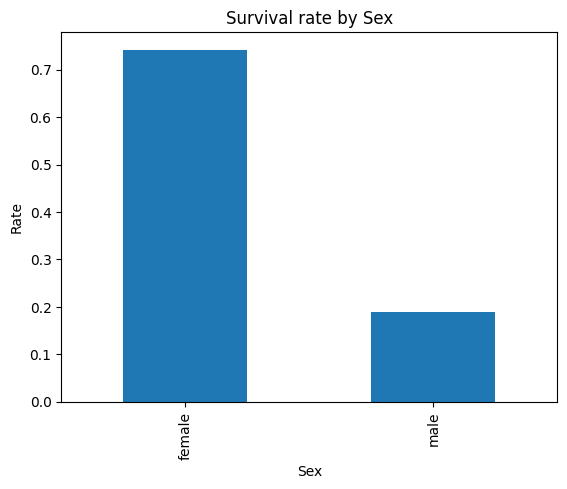

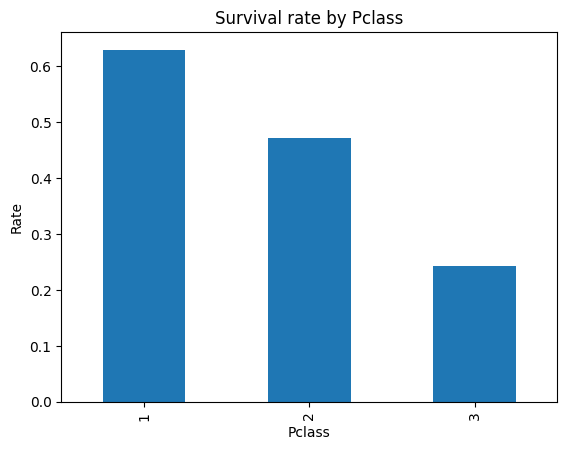

In [6]:
# Simple plots
train.groupby('Sex')['Survived'].mean().plot(kind='bar', title='Survival rate by Sex')
plt.ylabel('Rate'); plt.show()

train.groupby('Pclass')['Survived'].mean().plot(kind='bar', title='Survival rate by Pclass')
plt.ylabel('Rate'); plt.show()


Based on these results, it appears that women and 1st-class passengers had higher survival. This could indicate that `Sex`, `Pclass`, and `Fare` are strong features.

### Some feature engineering

Two helpful features seen in many Titanic kernels are `FamilySizes` and `IsAlone`

* **FamilySize** = `SibSp + Parch + 1`
* **IsAlone** = 1 if FamilySize == 1 else 0

* **sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

* **parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [7]:
def add_simple_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['FamilySize'] = out['SibSp'] + out['Parch'] + 1
    out['IsAlone'] = (out['FamilySize'] == 1).astype(int)
    return out

train_fe = add_simple_features(train)
test_fe  = add_simple_features(test)

train_fe[['SibSp','Parch','FamilySize','IsAlone','Survived']].head()


,SibSp,Parch,FamilySize,IsAlone,Survived
0,1,0,2,0,0
1,1,0,2,0,1
2,0,0,1,1,1
3,1,0,2,0,1
4,0,0,1,1,0


### Baseline

A **baseline** is a simple rule to beat. A naive one: predict everyone **not** survived (the majority class).

In [8]:
majority_class = train_fe['Survived'].mode()[0]
baseline_acc = (train_fe['Survived'] == majority_class).mean()
print(f"Baseline accuracy (predict all {majority_class}): {baseline_acc:.3f}")


Baseline accuracy (predict all 0): 0.616


### Validation split

We’ll keep a **validation** set to evaluate models before touching the official `test.csv`.

In [9]:
FEATURES = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','FamilySize','IsAlone']
TARGET   = 'Survived'

X = train_fe[FEATURES]
y = train_fe[TARGET]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_val.shape


((712, 9), (179, 9))

### Preprocessing with `ColumnTransformer` + `Pipeline`

* `ColumnTransformer`: [Applies transformers to columns of an array or pandas DataFrame.](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
* `Pipeline`: [A sequence of data transformers with an optional final predictor.](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

* **Numeric**: impute missing with median; optionally scale for LR.
* **Categorical**: impute with most frequent; one-hot encode.

In [10]:
numeric_features = ['Age','SibSp','Parch','Fare','FamilySize']
categorical_features = ['Pclass','Sex','Embarked','IsAlone']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))  # with_mean=False keeps sparse compatibility
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)


### Simple models

#### Logistic Regression

In [11]:
log_reg_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=1000))
])

log_reg_clf.fit(X_train, y_train)
y_val_pred = log_reg_clf.predict(X_val)
y_val_proba = log_reg_clf.predict_proba(X_val)[:,1]

print_metrics(y_val, y_val_pred, y_val_proba, label="LogReg")


[LogReg] Acc=0.816 | Prec=0.810 | Rec=0.681 | F1=0.740 | ROC-AUC=0.850


#### Decision Tree

In [12]:
tree_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', DecisionTreeClassifier(random_state=42))
])

tree_clf.fit(X_train, y_train)
y_val_pred_t = tree_clf.predict(X_val)
y_val_proba_t = tree_clf.predict_proba(X_val)[:,1]

print_metrics(y_val, y_val_pred_t, y_val_proba_t, label="DecisionTree")


[DecisionTree] Acc=0.771 | Prec=0.706 | Rec=0.696 | F1=0.701 | ROC-AUC=0.749


#### ROC Curve

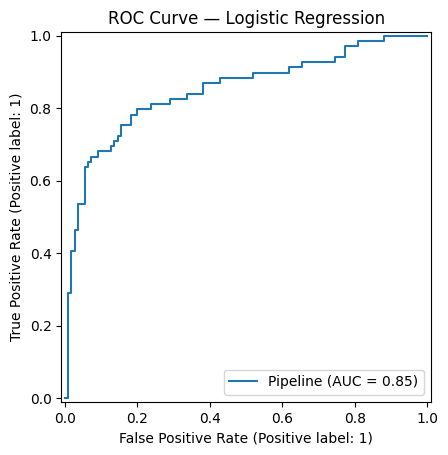

In [13]:
disp = RocCurveDisplay.from_estimator(log_reg_clf, X_val, y_val)
plt.title("ROC Curve — Logistic Regression")
plt.show()


### Hyperparameter tuning with `GridSearchCV`

* **GridSearchCV** implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

    The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.


In this step I'll use cross-validation to search a grid of options.

In [14]:
param_grid_lr = {
    'model__C': [0.1, 1.0, 3.0, 10.0],
    'model__penalty': ['l2'],  # (liblinear supports l1; saga supports l1/l2)
    'model__solver': ['lbfgs'] # standard for l2
}

grid_lr = GridSearchCV(
    Pipeline(steps=[('prep', preprocess),
                   ('model', LogisticRegression(max_iter=2000))]),
    param_grid=param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)
print("Best LR params:", grid_lr.best_params_)
y_pred = grid_lr.predict(X_val)
y_proba = grid_lr.predict_proba(X_val)[:,1]
print_metrics(y_val, y_pred, y_proba, label="GridSearch LR")


Best LR params: {'model__C': 1.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
[GridSearch LR] Acc=0.816 | Prec=0.810 | Rec=0.681 | F1=0.740 | ROC-AUC=0.850


Quick tree search:

In [15]:
param_grid_tree = {
    'model__max_depth': [3, 4, 5, 6, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_tree = GridSearchCV(
    Pipeline(steps=[('prep', preprocess),
                   ('model', DecisionTreeClassifier(random_state=42))]),
    param_grid=param_grid_tree,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)
print("Best Tree params:", grid_tree.best_params_)
y_pred_t = grid_tree.predict(X_val)
y_proba_t = grid_tree.predict_proba(X_val)[:,1]
print_metrics(y_val, y_pred_t, y_proba_t, label="GridSearch Tree")


Best Tree params: {'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
[GridSearch Tree] Acc=0.804 | Prec=0.804 | Rec=0.652 | F1=0.720 | ROC-AUC=0.823


The **Logistic Regression (LR)** model clearly shows better validation performance overall. Let’s compare metric by metric:

| Metric    | Logistic Regression | Decision Tree |         Better         |
| :-------- | :-----------------: | :-----------: | :--------------------: |
| Accuracy  |      **0.816**      |     0.804     |          LR            |
| Precision |      **0.810**      |     0.804     |          LR            |
| Recall    |      **0.681**      |     0.652     |          LR            |
| F1        |      **0.740**      |     0.720     |          LR            |
| ROC-AUC   |      **0.850**      |     0.823     |          LR            |

### Interpretation

* **Across all metrics**, the Logistic Regression model outperforms the Decision Tree, indicating it generalizes better on the validation set.
* The **higher ROC-AUC (0.85)** suggests the LR model ranks positives vs. negatives more effectively across thresholds.
* The **F1 score (0.74)** balances precision and recall well, showing good classification quality.
* Decision Trees tend to overfit small datasets; the regularized LR (`C=1.0, L2 penalty`) provides smoother, more stable decision boundaries.


### Interpretability (and why it matters)

For **Logistic Regression**, coefficients show directionality (positive => higher survival odds). Because we used one-hot encoding and scaling inside a pipeline, we can recover feature names:

In [16]:
best_lr = grid_lr.best_estimator_  # Pipeline(prep, model)
prep = best_lr.named_steps['prep']
ohe = prep.named_transformers_['cat'].named_steps['ohe']

num_names = numeric_features
cat_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = num_names + cat_names

coefs = best_lr.named_steps['model'].coef_.ravel()
importance = pd.Series(coefs, index=feature_names).sort_values(ascending=False)
importance.head(10), importance.tail(10)


(Sex_female    1.269194
 Pclass_1      0.981693
 Embarked_Q    0.339394
 IsAlone_0     0.306533
 Fare          0.110382
 Pclass_2      0.066322
 Embarked_C    0.002356
 Parch        -0.062198
 FamilySize   -0.221154
 SibSp        -0.282905
 dtype: float64,
 Pclass_2      0.066322
 Embarked_C    0.002356
 Parch        -0.062198
 FamilySize   -0.221154
 SibSp        -0.282905
 IsAlone_1    -0.305745
 Embarked_S   -0.340961
 Age          -0.476390
 Pclass_3     -1.047227
 Sex_male     -1.268406
 dtype: float64)

### Final training and results

Using `best_lr`, refit on **all** of `train_fe` for maximum data use, then predict `test_fe`.

In [ ]:
# Refit best model on ALL training data
best_model = grid_lr.best_estimator_
best_model.fit(X, y)

# Ensure test has the same engineered features/columns:
X_test = test_fe[FEATURES]

test_pred = best_model.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test_fe['PassengerId'],
    'Survived': test_pred.astype(int)
})
submission.to_csv("results.csv", index=False)
submission.head()
